In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import re
import glob
import seaborn as sns # for data visaulization
import matplotlib.pyplot as plt # also for data viz
import pyreadstat # importing .sav files
from pandas_profiling import ProfileReport



### Data Importation and Variable Selection

In [2]:
# Load the data; keep the value labels
df, meta = pyreadstat.read_sav('../Data/afro.sav', encoding = 'utf8', apply_value_formats = True)
df_orig = df
df.head()

,RESPNO,COUNTRY,COUNTRY_Old.order,COUNTRY_R5List,COUNTRY_R6List,COUNTRY.BY.REGION,URBRUR,REGION,LOCATION.LEVEL.1,EA_SVC_A,...,LivedPoverty,LivedPoverty_CAT,DemandDemo,SupplyDemo,R1.only,R2.only,R3.only,R4.only,R5.only,R6.only
0,BEN0001,Benin,Benin,Benin,Benin,West Africa,Rural,Mono,LOKOSSA,Yes,...,2.0,Moderate Lived Poverty,Agrees w/ 2 of 4 components,"Perceives supply of one, not both",Not Selected,Not Selected,Selected,Selected,Selected,Selected
1,BEN0002,Benin,Benin,Benin,Benin,West Africa,Rural,Mono,LOKOSSA,Yes,...,0.2,Low Lived Poverty,Full demand for democracy,Perceives full supply of democracy (Extent +Sa...,Not Selected,Not Selected,Selected,Selected,Selected,Selected
2,BEN0003,Benin,Benin,Benin,Benin,West Africa,Urban,Atlantique,ABOMEY-CALAVI,Yes,...,1.2,Moderate Lived Poverty,Full demand for democracy,Perceives no supply,Not Selected,Not Selected,Selected,Selected,Selected,Selected
3,BEN0004,Benin,Benin,Benin,Benin,West Africa,Urban,Atlantique,ABOMEY-CALAVI,Yes,...,0.2,Low Lived Poverty,Full demand for democracy,Perceives full supply of democracy (Extent +Sa...,Not Selected,Not Selected,Selected,Selected,Selected,Selected
4,BEN0005,Benin,Benin,Benin,Benin,West Africa,Urban,Atlantique,ABOMEY-CALAVI,Yes,...,1.6,Moderate Lived Poverty,Agrees w/ 2 of 4 components,"Perceives supply of one, not both",Not Selected,Not Selected,Selected,Selected,Selected,Selected


In [3]:
# done! let's see what we can get from the meta data
colnames = meta.column_names
collabels = meta.column_labels

# generate table containing column names and corresponding column labels
var_dict = {'col_names': colnames, 'col_labels': collabels}
var_df = pd.DataFrame(var_dict)
var_df.head()

,col_names,col_labels
0,RESPNO,Respondent number
1,COUNTRY,Country
2,COUNTRY_Old.order,Country in R7 Old Alphabetical Order
3,COUNTRY_R5List,Country in R5 Alphabetical Order
4,COUNTRY_R6List,Country in R6 Alphabetical Order


In [4]:
# To get the variable names, search the 'col_labels' column of varList dataframe using keywords of variables to be used
mask = var_df['col_labels'].str.lower().str.contains('bribe|difficult')
var_df[mask]

,col_names,col_labels
161,Q48A,Q48a. Ordinary person: pay bribe to avoid taxes
162,Q48B,Q48b. Ordinary person: pay bribe to avoid goin...
163,Q48C,Q48c. Ordinary person: pay bribe to register l...
164,Q48D,Q48d. Rich person: pay bribe to avoid taxes
165,Q48E,Q48e. Rich person: pay bribe to avoid going to...
166,Q48F,Q48f. Rich person: pay bribe to register land ...
168,Q49B,Q49b. Difficulty to obtain public school services
169,Q49C,Q49c. Pay bribe for public school services
171,Q49E,Q49e. Difficulty to obtain medical care
173,Q49G,Q49g. Pay bribe for medical care


In [5]:
# Exclude non-required variables from dataframe
req_vars = ['COUNTRY', 'AGE_COND', 'Q101', 'URBRUR_COND', 'LivedPoverty_CAT', 'EDUC_COND', 'Q20A', 'Q20B', 'Q49B' , 'Q49E', 'Q49I', 'Q49M', 'Q49P', 'Q49N']
df = df[req_vars]

df.rename(columns={'COUNTRY': 'country', 'AGE_COND': 'age', 'Q101': 'gender', 'URBRUR_COND': 'urban', \
                   'LivedPoverty_CAT': 'poverty', 'EDUC_COND': 'educ', 'Q20A': 'mem_reli', 'Q20B': 'mem_comgrp', 'Q49B': 'pschool_user', \
                   'Q49E': 'pmedic_user', 'Q49I': 'pid_user', 'Q49M': 'phouse_user', 'Q49P': 'ppolice_user','Q49N': 'bribery'}, inplace = True)

### Data Wrangling

In [6]:
# Compute number of missing values
print(df.isnull().sum())

# Check categories contained in each variable
for col in df.columns:
  print(df[col].unique().tolist())

# replace Often, Missing, and Refused with NaNs
df.replace({"Missing": np.nan, "Don't know": np.nan, "Refused": np.nan}, inplace= True)  # categorical dtypes are apparently non-hashable, so putting the values to replace in a list doesn't work here

# Drop rows with NAs
df.dropna(axis=0, inplace = True)

# Check if there are any missing values
print('\n', df.isnull().sum().sum(), '\n')

# Check to see the size of the data
print(df.shape)



country           0
age               0
gender            0
urban             0
poverty         471
educ             63
mem_reli          0
mem_comgrp        0
pschool_user      0
pmedic_user       0
pid_user          0
phouse_user       0
ppolice_user      0
bribery           0
dtype: int64
['Benin', 'Botswana', 'Burkina Faso', 'Cabo Verde', 'Cameroon', "Côte d'Ivoire", 'eSwatini', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'São Tomé and Príncipe', 'Senegal', 'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']
['18-25', '36-45', '26-35', '46-55', 'Over 65', "Don't know", '56-65']
['Female', 'Male', 'Missing']
['Rural', 'Urban']
['Moderate Lived Poverty', 'Low Lived Poverty', 'High Lived Poverty', 'No Lived Poverty', nan]
['Secondary', 'Primary', 'Post-secondary', 'No formal education', "Don't know", nan]
['No

Initial sample size is `45823` observations. We drop rows with at least one missing or invalid value from our data, resulting into a sample size of `44381` observations. 

In [7]:
# Encode the categorical values to denote those without contact and those that made contact for public services
sub_df = df.loc[:, df.columns.str.contains('user')].copy()
sub_df.replace('No contact', 0, inplace=True)
sub_df.replace(['Difficult', 'Easy', 'Very Difficult', 'Very easy'], 1, inplace=True)

sub_df = sub_df.astype('int64')
print(sub_df.describe())

       pschool_user   pmedic_user      pid_user   phouse_user  ppolice_user
count  44381.000000  44381.000000  44381.000000  44381.000000  44381.000000
mean       0.358104      0.612988      0.347514      0.168022      0.133999
std        0.479448      0.487072      0.476186      0.373890      0.340655
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        0.000000      1.000000      0.000000      0.000000      0.000000
75%        1.000000      1.000000      1.000000      0.000000      0.000000
max        1.000000      1.000000      1.000000      1.000000      1.000000


People rarely used police service (approx. 14% of resppondents), while only 16.8% of repsondents contact the government for water and sanitation services. Public medical services had the highest patronage (61.2% of respondents)

In [8]:
# Create an index for usage of all public sector services; add to df
sub_df['psector_user'] = sub_df.sum(axis=1) 

merged_df = pd.concat((df.drop(['pschool_user', 'pid_user', 'pmedic_user', 'ppolice_user'], axis = 1), sub_df[['psector_user']]), axis = 1)

# Restrict data to respondents that contacted the government for WatSan services
merged_df_filtered = merged_df[merged_df['phouse_user'] != 'No contact']
print(merged_df_filtered.shape)

(7457, 11)


Final sample size contains 7457 observations.

In [9]:
# Reconstruct bribery variable into a binary variable
print(merged_df_filtered['bribery'].value_counts(), "\n")
merged_df_filtered['bribery'] = np.where(merged_df_filtered['bribery'].isin(['Never', 'No contact']), 'No experience', 'Experience')

# Change the order of categories
merged_df_filtered['poverty'] = merged_df_filtered['poverty'].cat.reorder_categories(['High Lived Poverty', 'Moderate Lived Poverty', 'Low Lived Poverty', 'No Lived Poverty'])

Never            5962
Once or twice     748
A few times       469
Often             278
Name: bribery, dtype: int64 



### Descriptive Statistics

In [10]:
print(merged_df_filtered.bribery.value_counts(normalize=True))

No experience    0.799517
Experience       0.200483
Name: bribery, dtype: float64


A substantially large proportion of Africans (80%) report having no experience with paying bribes to obtain water and sanitation services. 

In [39]:
# Top and bottom 5 countries
df_to_sort = merged_df_filtered.groupby('country').bribery.value_counts(normalize = True).round(3).to_frame().rename_axis(['country', 'bribery_exp'])
df_to_sort = df_to_sort.pivot_table(index='country', columns = 'bribery_exp', values='bribery').reset_index()
df_sorted = df_to_sort.sort_values(by = 'Experience', ascending=False).reset_index(drop=True)

# function to plot top and bottom n countries
def plot_n(input_df, n, bottom = True):
  """Plots top or bottom n countries
  Arg: 
  input_df  : A dataframe
  n : number of countries to plot
  bottom  :  Plot bottom n countries if True, and top n countries if False. Default is True

  Returns: Returns a plot 
  """

  # Set context of the plot
  sns.set_context("talk")
  sns.set_style("white")
  f, ax = plt.subplots(figsize=(13, 8))

  if bottom == False:
    plot_df = input_df.iloc[:n, :]
  else:
    plot_df = input_df.iloc[-n:, :] 

  plot_df['country'] = plot_df.country.cat.remove_unused_categories()
  sns.barplot(y = 'country', x = 'Experience', data = plot_df, color = 'teal', ci = None, order = plot_df['country'])

  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width())
    x = p.get_x() + p.get_width() - 0.00000008
    y = p.get_y() + p.get_height()/2 + 0.1
    ax.annotate(percentage, (x, y))

  ax.set(xlabel =None, ylabel = None, xticklabels=[])  
  sns.despine(bottom=True, right = True) # removes bottom and right borders
  plt.show()
    



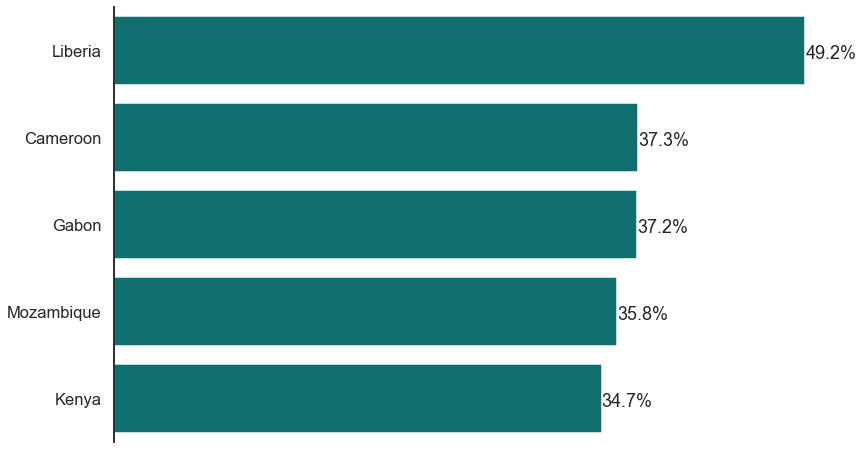

In [29]:
# Top 5 countries
plot_n(df_sorted, 5, bottom=False)

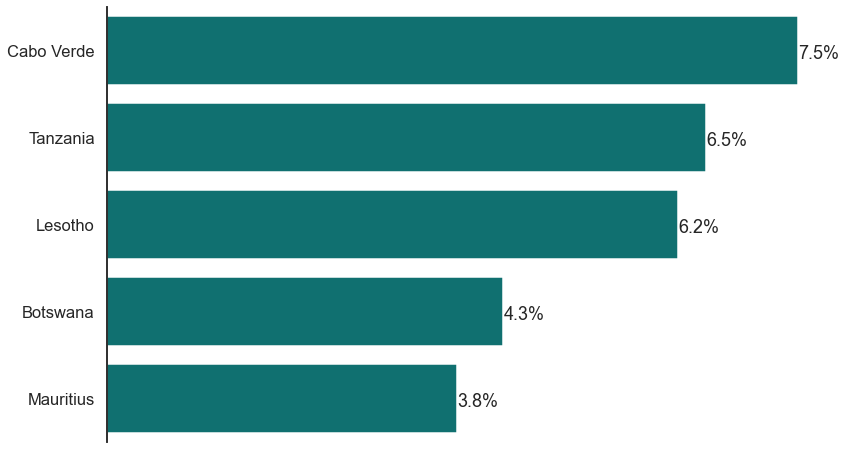

In [31]:
# Bottom 5 countries
plot_n(df_sorted, 5)

In [40]:
# function to generate two-way plots for prevalence of bribe
def plot_2way(input_df, grp, var = 'bribery'):
  """Generate two-way plot
  Arg: 
  input_df  : A dataframe
  grp : Independent variable
  var : Dependent variable (Default is 'bribery')
  """
  # Set context of the plot
  sns.set_context("talk")
  sns.set_style("white")
  f, ax = plt.subplots(figsize=(13, 10))

  new_df = input_df.groupby(grp)[var].value_counts(normalize=True).unstack()
  new_df.plot(kind='barh', stacked='True', ax = ax, color = ["#008080", "#00CCCC"], width = 0.4)

  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width())
    x= p.get_x() + p.get_width() -0.09
    y = p.get_y() + p.get_height()/2  
    ax.annotate(percentage, (x, y), ha='center', va='center')

  ax.set(xlabel =None, ylabel = None, xticklabels=[]) 
  sns.despine(bottom=True, right = True)
  # set legend box outside the plot area: remove and return the different arguments to see what they do
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2) 
  plt.show()


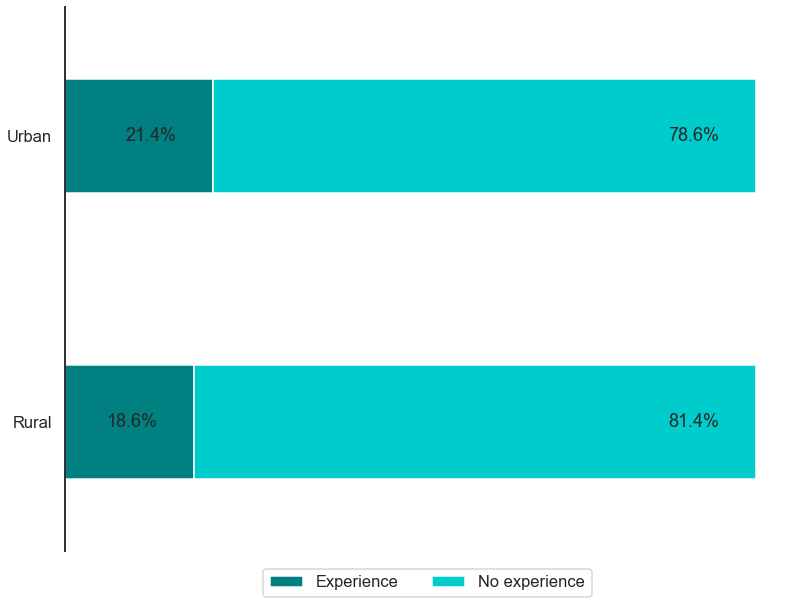

In [41]:
# Plot by settlement 
plot_2way(merged_df_filtered, "urban")

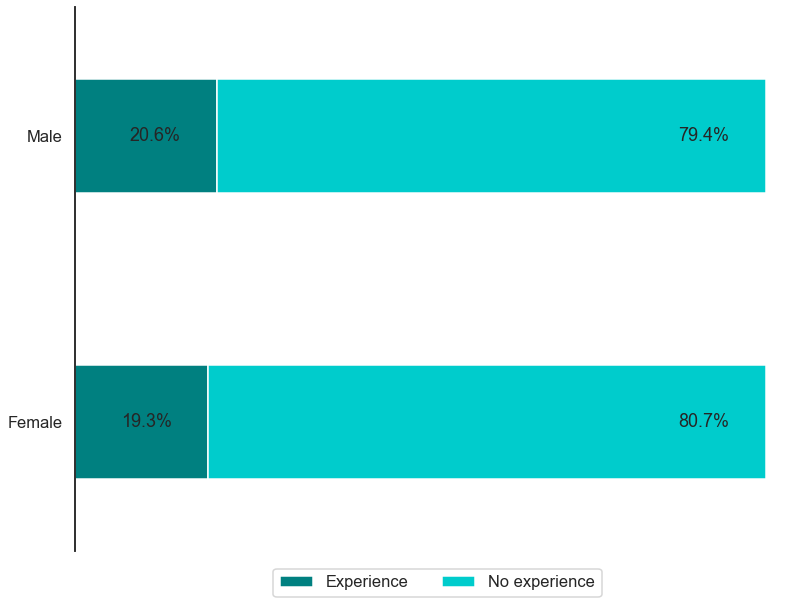

In [42]:
# Plot by Gender
plot_2way(merged_df_filtered, 'gender')

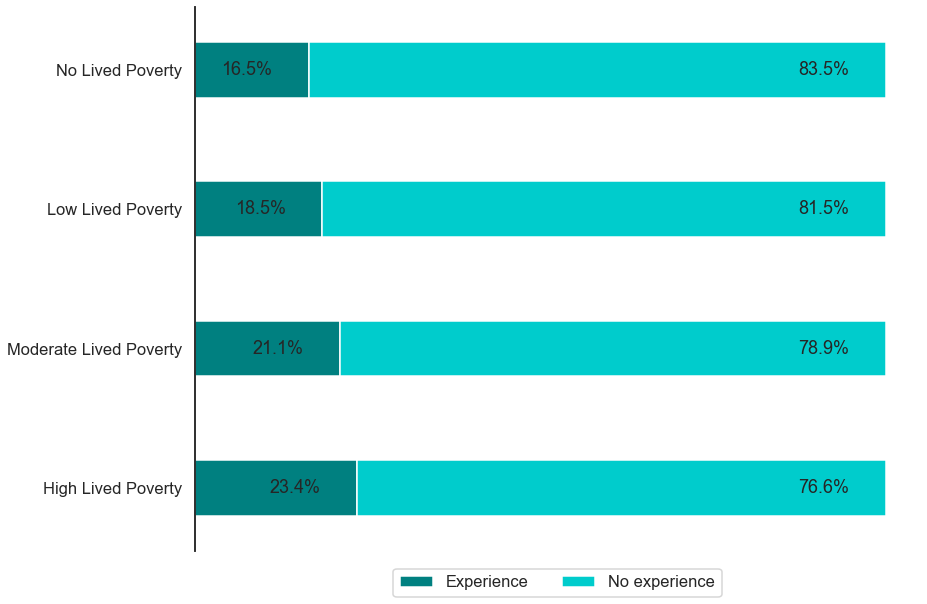

In [43]:
# Plot by Poverty Level
plot_2way(merged_df_filtered, 'poverty')

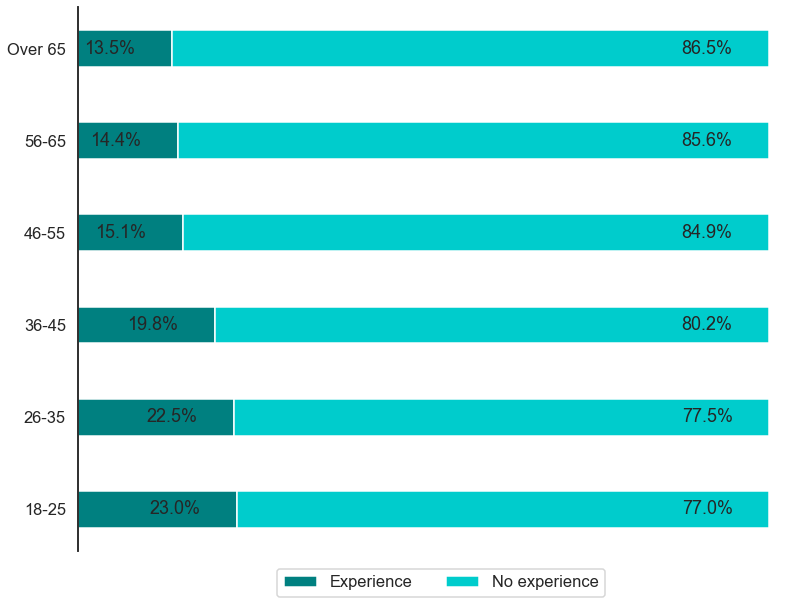

In [45]:
# Plot by Age
plot_2way(merged_df_filtered, 'age')